In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/holmes-txt/holmes.txt


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re

In [2]:
# Specify the filename
input_file = '/kaggle/input/holmes-txt/holmes.txt'

# Read the contents of the file
with open(input_file, 'r', encoding='utf-8') as infile:
    data = infile.read()

In [3]:
data[:100] # view first few characters

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swi"

In [4]:
# Limit data to 500000 characters
data = data[:500000]

In [5]:
# Function to remove emojis and special characters from text
def remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    
    return text

In [6]:
# Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized

# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)

What is an OOV Token?
An out-of-vocabulary (OOV) token is a special token used in natural language processing (NLP) tasks to represent words that
are not present in the vocabulary of the model or tokenizer. When a word that is not in the vocabulary is encountered during
tokenization or text processing, it is replaced with the OOV token.

Why Use an OOV Token?
Using an OOV token helps handle unseen or unknown words during the training or inference phase of an NLP model. 
Instead of encountering errors or issues when encountering unknown words, the model can gracefully handle them by
representing them with the OOV token. This is particularly useful when working with real-world data where the vocabulary
of the model may not cover all possible words.

In [8]:
# Tokenize words
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1
#tokenizer.word_counts
#tokenizer.word_index

n_gram example:
[3, 15, 8, 7, 20, 12, 6]

For the above sentece sentence, the code would generate the following n-gram sequences:

[3, 15]
[3, 15, 8]
[3, 15, 8, 7]
[3, 15, 8, 7, 20]
[3, 15, 8, 7, 20, 12]
[3, 15, 8, 7, 20, 12, 6]

In [9]:
# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [10]:
# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [11]:
# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [12]:
# Define your model
model = Sequential()
model.add(Embedding(total_words, 100)) 
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_temp, y_train_temp, epochs=50, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.0977 - loss: 6.2987 - val_accuracy: 0.1369 - val_loss: 5.6762
Epoch 2/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.1514 - loss: 5.3036 - val_accuracy: 0.1394 - val_loss: 6.1043
Epoch 3/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.1605 - loss: 5.1539 - val_accuracy: 0.1195 - val_loss: 6.5606
Epoch 4/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.1729 - loss: 5.0064 - val_accuracy: 0.1385 - val_loss: 6.4523
Epoch 5/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.1930 - loss: 4.4318 - val_accuracy: 0.1260 - val_loss: 6.6304
Epoch 6/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2107 - loss: 4.1339 - val_accuracy: 0.1255 - val_loss: 6.9405
Epoch 7/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2199 - loss: 3.9874 - val_accuracy: 0.1386 - val_loss: 7.2230
Epoch 8/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2237 - loss: 3

In [13]:
 # Save model architecture as JSON file
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
     json_file.write(model_json)

In [15]:
 # Load model architecture from JSON file
from tensorflow.keras.models import model_from_json

with open("lstm_model.json", "r") as json_file:
     loaded_model_json = json_file.read()

 # Create model from loaded architecture
 loaded_model = model_from_json(loaded_model_json)

 print("Model architecture loaded successfully from JSON file.")

Model architecture loaded successfully from JSON file.


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

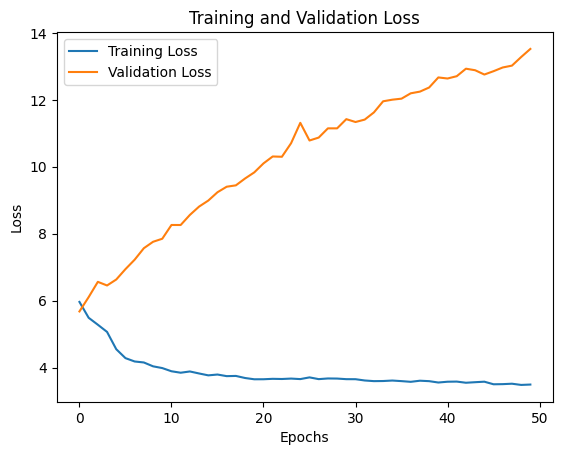

In [17]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

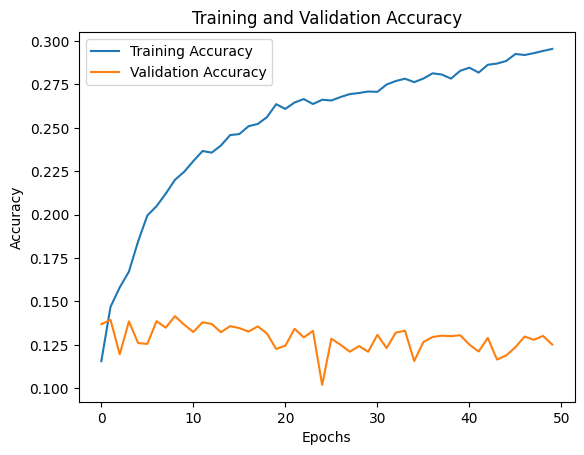

In [18]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

In [20]:
from IPython.display import HTML

def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

def predict_and_display_top_five_words(seed_text, model, tokenizer):
    top_five_words = predict_top_five_words(model, tokenizer, seed_text)
    heading_app = f"<h1>Sentence AutoCompletion App With Five Outputs</h1>"
    output_text = f"<ul>{''.join([f'<li>{seed_text} {word}</li>' for word in top_five_words])}</ul>"
    javascript_code = f"""
    <script>
        var newWindow = window.open("", "_blank");
        newWindow.document.write('<html><head><title>Top Five Words</title></head><body>{heading_app} <br> <hr> {output_text}</body></html>');
    </script>
    """
    return HTML(javascript_code)

In [23]:
# Test the function
seed_text = "She is my"
predict_and_display_top_five_words(seed_text, loaded_model, tokenizer)

In [24]:
# Test 2:
# Test the function
seed_text = "I have"
predict_and_display_top_five_words(seed_text, loaded_model, tokenizer)